In [1]:
import torch
print(torch.cuda.is_available())

True


In [1]:
# Libraries
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertModel
from sklearn.model_selection import train_test_split
from datetime import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import re

# methods
def data_cleaning(data):
    # cleaning repetitive char
    data = re.sub(r'(.)\1+', r'\1', data)
    # cleaning usernames
    data = re.sub('@[^\s]+', ' ', data)
    # cleaning URLs
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|([^\s]+\.com))',' ',data)
    # cleaning numerical numbers
    data = re.sub('[0-9]+', '', data)
    return data

# prepare dataset
df = pd.read_csv(r'C:\Users\Senju\Documents\_Solent\_Dissertation\training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.columns=['label','b','c','d','e','tweet']
df = df[['label','tweet']] # label aka class label, target variable
df.loc[df['label'] == 4, 'label'] = 1 # convert all values of 4 to 1 (positive sentiment)
positive = df[df['label'] == 1] # split the dataframe into positive and negative sentiment
negative = df[df['label'] == 0]
positive = positive.iloc[:int(50000)] # reducing the data for smoother operation flow
negative = negative.iloc[:int(50000)]
df = pd.concat([positive, negative]) # combine into one dataframe

# data cleaning
df['tweet'] = df['tweet'].apply(lambda x: data_cleaning(x))

df.head()

,label,tweet
800000,1,I LOVE u guys r the best!
800001,1,im meting up with one of my besties tonight! C...
800002,1,"Thanks for the Twiter ad, Sunisa! I got to m..."
800003,1,Being sick can be realy cheap when it hurts to...
800004,1,he has that efect on everyone


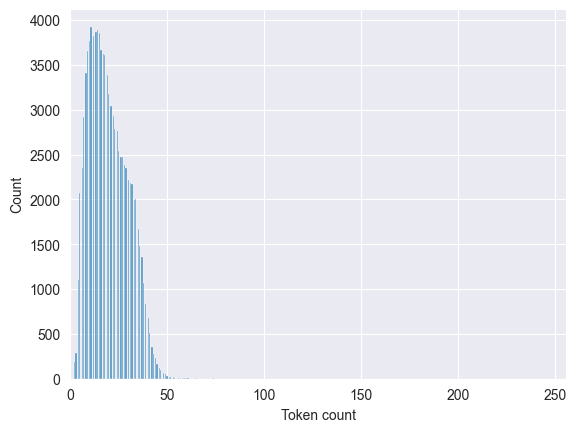

In [2]:
# X (input), y (output)
X = df['tweet']
y = df['label']

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
# plot the distribution of review lengths 
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

# plt.savefig(r'C:\Users\Senju\Documents\_Solent\_Dissertation\final_report\diagrams\dbert_pt_max_length.png')

In [3]:
X_list=X.to_list()
X_token = tokenizer(X_list, padding='max_length', max_length = 120, truncation=True, return_tensors='pt')["input_ids"]
# mask = tokenizer(X_list, padding='max_length', max_length = 120, truncation=True, return_tensors='pt')["attention_mask"]
# attention mask should be passed if using max_length = 120, since input_ids may be padded

y_list=y.tolist()
y_token = torch.Tensor(y_list).long()

# Train set size (80%) test set size (20%)
X_train, X_test, y_train, y_test = train_test_split(X_token, y_token, test_size=0.2, random_state=42, stratify=y_token)

In [4]:
# Convert data to torch dataset
class TweetDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y
        

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
    
# Convert train and test data to Dataset class
train_data = TweetDataset(X=X_train, y=y_train)
test_data = TweetDataset(X=X_test, y=y_test)

In [5]:
# Get train and test data in form of Dataloader class
train_DataLoader = DataLoader(train_data, batch_size=32)
test_DataLoader = DataLoader(test_data, batch_size=32)

In [6]:
# Get Bert layer
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

In [7]:
# Set GPU (CUDA) as device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dbert
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        # x = torch.linspace(-1, 1, 32)
        logits = self.linear2(x)
        # Softmax already included in the CrossEntropyLoss
        return logits

model = DistilBertClassification().to(device)

print(model)

Using cuda device
DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)

In [8]:
for param in model.dbert.parameters():
    param.requires_grad = False

In [9]:
total_params = sum(p.numel() for p in model.parameters())
total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66412421
Number of trainable parameters:  49541


In [10]:
epochs = 2
# criterion = torch.nn.BCELoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Measure time for training
start_time = datetime.now()

# Loop on epochs
for e in range(epochs):
    
    # Set mode in train mode
    model.train()
    
    train_loss = 0.0
    train_accuracy = []
    
    # Loop on batches
    for X, y in tqdm(train_DataLoader):
        X = X.cuda()
        y = y.cuda()
        '''Line 27 and 28 solves the following error: 
        RuntimeError: Expected all tensors to be on the same device, 
        but found at least two devices, cuda:0 and cpu! 
        (when checking argument for argument index in method wrapper_CUDA__index_select)'''
        
        # Get prediction & loss
        prediction = model(X)
        loss = criterion(prediction, y)
        
        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy
    
    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item()
    
    # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in test_DataLoader:
        X = X.cuda()
        y = y.cuda()
         
        prediction = model(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()
    
    # Populate history
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_DataLoader))
    history["valid_loss"].append(valid_loss / len(test_DataLoader))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)    
        
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_DataLoader) :10.3f} \t\t Validation Loss: {valid_loss / len(test_DataLoader) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')
    # Categorical accuracy
    
# Measure time for training
end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

100%|██████████| 2500/2500 [01:48<00:00, 23.04it/s]


Epoch 1 		 Training Loss:      0.674 		 Validation Loss:      0.641
		 Training Accuracy:    58.025% 		 Validation Accuracy:    62.820%


100%|██████████| 2500/2500 [01:48<00:00, 22.99it/s]


Epoch 2 		 Training Loss:      0.660 		 Validation Loss:      0.628
		 Training Accuracy:    60.170% 		 Validation Accuracy:    67.485%


In [11]:
save_as = 'distilBERT_pt_epoch2'

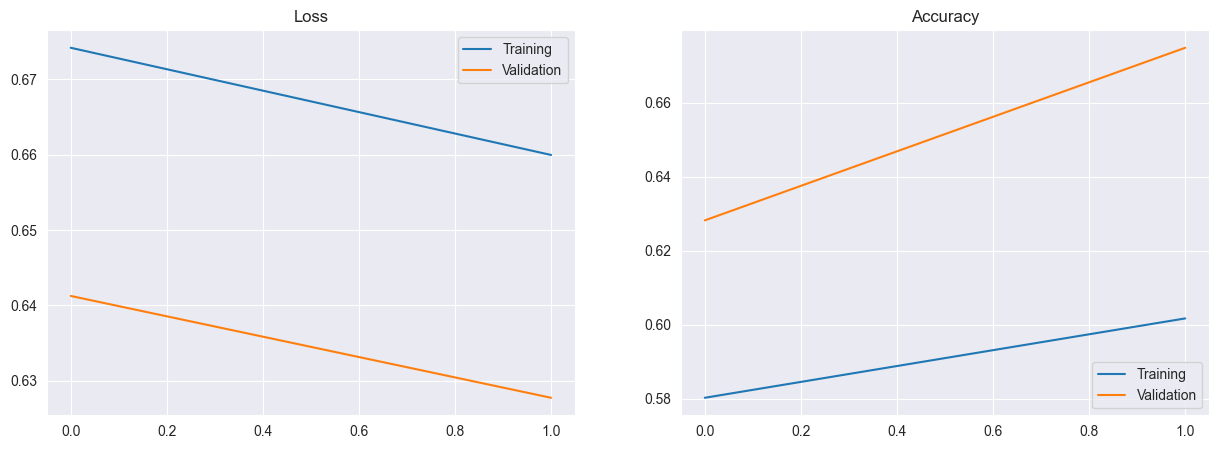

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

plt.savefig(r'C:\Users\Senju\Documents\_Solent\_Dissertation\final_report\diagrams\\' + save_as + '.png')

In [13]:
accuracy = history['valid_accuracy'][-1]
print('Training accuracy: {:.1%}'.format(history['train_accuracy'][-1]))
print('Validation accuracy: {:.1%}'.format(history['valid_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time, training_time/60))

Training accuracy: 60.2%
Validation accuracy: 67.5%
Training time: 270.4s (or 4.5 minutes)


In [14]:
save_as = save_as + '.sd'

In [15]:
# save trained model
torch.save(model.state_dict(), save_as)

In [28]:
from transformers import DistilBertConfig, DistilBertModel
from torch import nn

# load existing model
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dbert
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        # softmax already included in the CrossEntropyLoss
        return logits

model2 = DistilBertClassification()
model2.load_state_dict(torch.load(save_as))
model2.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1